Path to dataset files: /kaggle/input/tiny-imagenet
فایل words.txt پیدا شد: /kaggle/input/tiny-imagenet/tiny-imagenet-200/words.txt
پوشه train پیدا شد: /kaggle/input/tiny-imagenet/tiny-imagenet-200/train
پوشه val پیدا شد: /kaggle/input/tiny-imagenet/tiny-imagenet-200/val
پوشه test پیدا شد: /kaggle/input/tiny-imagenet/tiny-imagenet-200/test

آمار دیتاست:
Train: 100000 تصویر
Validation: 10000 تصویر
Test: 10000 تصویر
کل: 120000 تصویر

نمایش نمونه تصاویر از بخش Train (تعداد: 5):


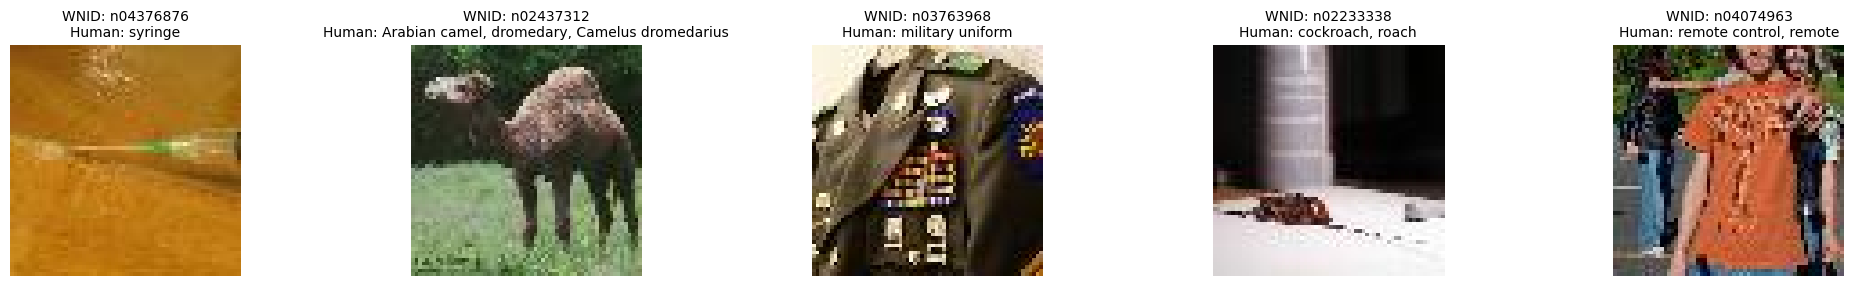


نمایش نمونه تصاویر از بخش Validation (تعداد: 5):


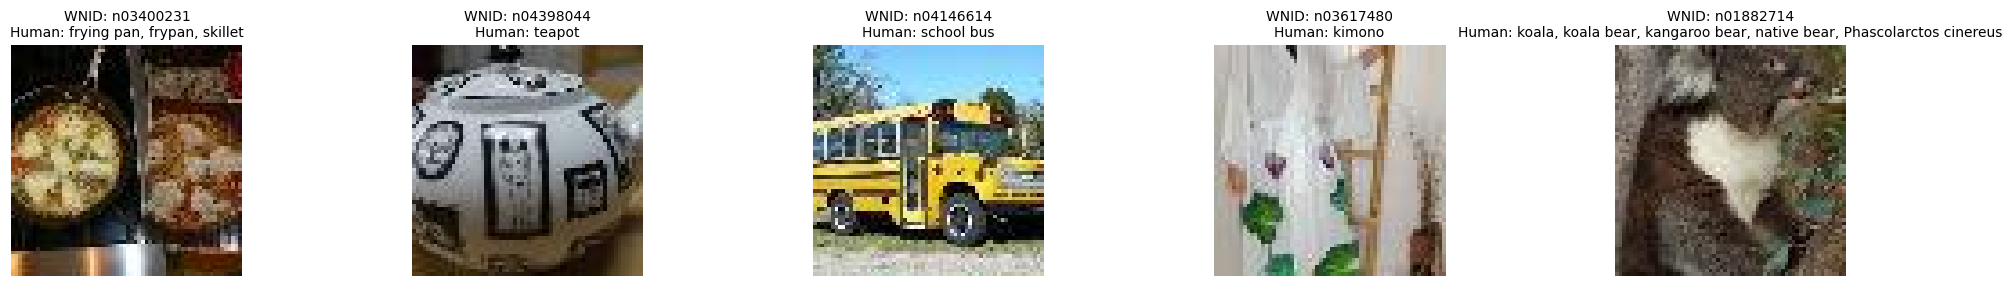


نمایش نمونه تصاویر از بخش Test (تعداد: 5):


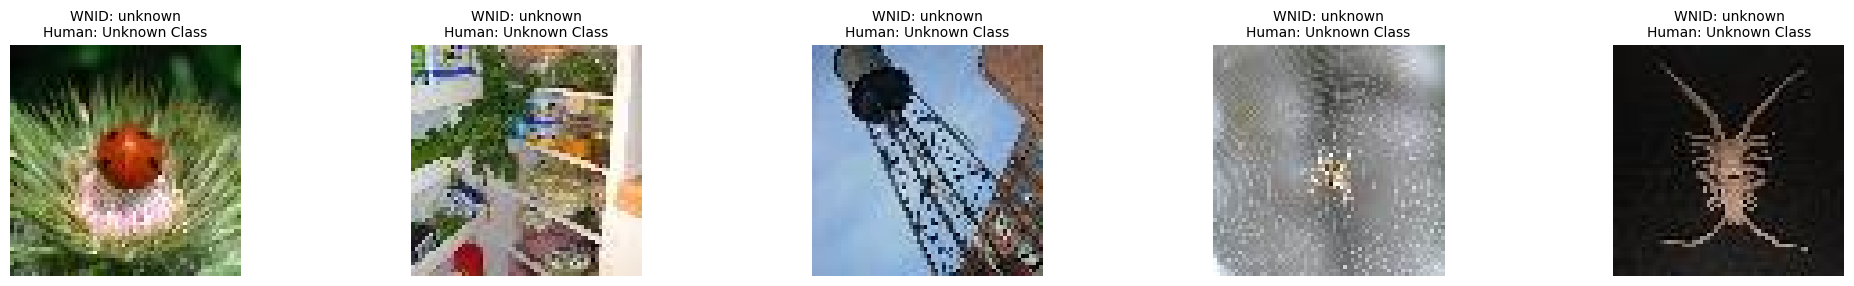


داده‌ها با موفقیت در /content/custom_split ذخیره شدند. تعداد کل تصاویر: 120000


In [ ]:
import kagglehub
import os
import random 
import shutil  
from PIL import Image
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")
print("Path to dataset files:", path)

words_file = None
for root, _, files in os.walk(path):
    if 'words.txt' in files:
        words_file = os.path.join(root, 'words.txt')
        break

wnid_to_label = {}
if words_file and os.path.exists(words_file):
    print(f"فایل words.txt پیدا شد: {words_file}")
    with open(words_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                wnid, label = parts[0], parts[1]
                wnid_to_label[wnid] = label
else:
    print("هشدار: فایل words.txt یافت نشد. از WNIDها به‌عنوان لیبل استفاده می‌شود.")

train_path = None
val_path = None
test_path = None
for root, dirs, _ in os.walk(path):
    if 'train' in dirs and train_path is None:
        train_path = os.path.join(root, 'train')
    if 'val' in dirs and val_path is None:
        val_path = os.path.join(root, 'val')
    if 'test' in dirs and test_path is None:
        test_path = os.path.join(root, 'test')

if train_path is None or not os.path.exists(train_path):
    raise FileNotFoundError(f"پوشه train در مسیر {path} یافت نشد.")
if val_path is None or not os.path.exists(val_path):
    raise FileNotFoundError(f"پوشه val در مسیر {path} یافت نشد.")
if test_path is None or not os.path.exists(test_path):
    raise FileNotFoundError(f"پوشه test در مسیر {path} یافت نشد.")

print(f"پوشه train پیدا شد: {train_path}")
print(f"پوشه val پیدا شد: {val_path}")
print(f"پوشه test پیدا شد: {test_path}")

val_annotations_file = os.path.join(val_path, 'val_annotations.txt')
val_labels = {}
if os.path.exists(val_annotations_file):
    with open(val_annotations_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                img_name, wnid = parts[0], parts[1]
                val_labels[img_name] = wnid
else:
    raise FileNotFoundError(f"فایل val_annotations.txt در مسیر {val_path} یافت نشد.")

custom_split_path = '/content/custom_split'
os.makedirs(custom_split_path, exist_ok=True)

for split in ['train', 'validation', 'test']:
    split_path = os.path.join(custom_split_path, split)
    os.makedirs(split_path, exist_ok=True)

train_data = []
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        image_path = os.path.join(class_dir, 'images')
        if os.path.exists(image_path):
            class_split_path = os.path.join(custom_split_path, 'train', class_name)
            os.makedirs(class_split_path, exist_ok=True)
            images = [f for f in os.listdir(image_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for img_file in images:
                img_path = os.path.join(image_path, img_file)
                new_img_path = os.path.join(class_split_path, img_file)
                shutil.copy(img_path, new_img_path)
                wnid_label = class_name
                human_label = wnid_to_label.get(class_name, class_name)
                train_data.append({
                    'image_path': new_img_path,
                    'wnid_label': wnid_label,
                    'human_label': human_label
                })

val_data = []
val_images_path = os.path.join(val_path, 'images')
if os.path.exists(val_images_path):
    images = [f for f in os.listdir(val_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_file in images:
        if img_file in val_labels:
            wnid_label = val_labels[img_file]
            human_label = wnid_to_label.get(wnid_label, wnid_label)
            img_path = os.path.join(val_images_path, img_file)
            class_split_path = os.path.join(custom_split_path, 'validation', wnid_label)
            os.makedirs(class_split_path, exist_ok=True)
            new_img_path = os.path.join(class_split_path, img_file)
            shutil.copy(img_path, new_img_path)
            val_data.append({
                'image_path': new_img_path,
                'wnid_label': wnid_label,
                'human_label': human_label
            })
test_data = []
test_images_path = os.path.join(test_path, 'images')
if os.path.exists(test_images_path):
    images = [f for f in os.listdir(test_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_file in images:
        wnid_label = 'unknown'
        human_label = 'Unknown Class'
        img_path = os.path.join(test_images_path, img_file)
        class_split_path = os.path.join(custom_split_path, 'test', 'unknown')
        os.makedirs(class_split_path, exist_ok=True)
        new_img_path = os.path.join(class_split_path, img_file)
        shutil.copy(img_path, new_img_path)
        test_data.append({
            'image_path': new_img_path,
            'wnid_label': wnid_label,
            'human_label': human_label
        })

print("\nآمار دیتاست:")
print(f"Train: {len(train_data)} تصویر")
print(f"Validation: {len(val_data)} تصویر")
print(f"Test: {len(test_data)} تصویر")
print(f"کل: {len(train_data) + len(val_data) + len(test_data)} تصویر")

def display_sample_images(data, split_name, num_samples=5):
    if not data:
        print(f"داده‌ای برای نمایش در بخش {split_name} وجود ندارد.")
        return
    print(f"\nنمایش نمونه تصاویر از بخش {split_name} (تعداد: {num_samples}):")
    plt.figure(figsize=(25, 3))
    sample_indices = random.sample(range(len(data)), min(num_samples, len(data)))
    for i, idx in enumerate(sample_indices):
        img = Image.open(data[idx]['image_path'])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"WNID: {data[idx]['wnid_label']}\nHuman: {data[idx]['human_label']}", fontsize=10)
        plt.axis('off')
    plt.show()

display_sample_images(train_data, 'Train')
display_sample_images(val_data, 'Validation')
display_sample_images(test_data, 'Test')

print(f"\nداده‌ها با موفقیت در {custom_split_path} ذخیره شدند. تعداد کل تصاویر: {len(train_data) + len(val_data) + len(test_data)}")

# **جدید ترین نسخه **


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "/content/custom_split"

class InceptionBlock(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(InceptionBlock, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.ReLU()
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.branch5 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.branchPool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.ReLU()
        )
        self.shortcut = nn.Conv2d(inChannels, outChannels * 4, kernel_size=1)

    def forward(self, x):
        residual = self.shortcut(x)
        out1 = self.branch1(x)
        out3 = self.branch3(x)
        out5 = self.branch5(x)
        outPool = self.branchPool(x)
        out = torch.cat([out1, out3, out5, outPool], dim=1)
        return F.relu(out + residual)

class ResidualBlock(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
        self.skip = nn.Conv2d(inChannels, outChannels, kernel_size=1)

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.conv2(out)
        return F.relu(out + identity)

class ResIncepCNNBase(nn.Module):
    def __init__(self, numClasses=200):
        super(ResIncepCNNBase, self).__init__()
        self.block1 = InceptionBlock(3, 16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block3 = InceptionBlock(128, 32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block4 = ResidualBlock(128, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.globalPool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, numClasses)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = self.pool3(x)
        x = self.block4(x)
        x = self.pool4(x)
        x = self.globalPool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ResIncepCNNWithBNDropout(nn.Module):
    def __init__(self, numClasses=200, dropoutProb=0.5):
        super(ResIncepCNNWithBNDropout, self).__init__()
        self.block1 = InceptionBlock(3, 16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block3 = InceptionBlock(128, 32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block4 = ResidualBlock(128, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.globalPool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 512)
        self.bnFc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(p=dropoutProb)
        self.fc2 = nn.Linear(512, numClasses)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = self.pool3(x)
        x = self.block4(x)
        x = self.pool4(x)
        x = self.globalPool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bnFc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

trainDataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers=2)
valDataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=False, num_workers=2)

def topKAccuracy(output, target, k=1):
    _, pred = output.topk(k, dim=1, largest=True, sorted=True)
    correct = pred.eq(target.view(-1, 1).expand_as(pred))
    return correct.float().sum().item() / target.size(0)


def evaluate(model, loader):
    model.eval()
    runningLoss = 0.0
    runningTop1 = 0.0
    runningTop5 = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            runningLoss += loss.item()
            runningTop1 += topKAccuracy(outputs, labels, k=1)
            runningTop5 += topKAccuracy(outputs, labels, k=5)
    nBatches = len(loader)
    return runningLoss / nBatches, runningTop1 / nBatches, runningTop5 / nBatches


def trainModel(model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30):
    trainLosses, trainTop1, trainTop5 = [], [], []
    valLosses, valTop1, valTop5 = [], [], []

    for epoch in range(numEpochs):
        model.train()
        runningLoss = 0.0
        runningAcc1 = 0.0
        runningAcc5 = 0.0
        for inputs, labels in tqdm(trainLoader, desc=f"Epoch {epoch+1}/{numEpochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
            runningAcc1 += topKAccuracy(outputs, labels, k=1)
            runningAcc5 += topKAccuracy(outputs, labels, k=5)

        if scheduler:
            scheduler.step()

        nBatchesTrain = len(trainLoader)
        trainLosses.append(runningLoss / nBatchesTrain)
        trainTop1.append(runningAcc1 / nBatchesTrain)
        trainTop5.append(runningAcc5 / nBatchesTrain)

        valLoss, valAcc1, valAcc5 = evaluate(model, valLoader)
        valLosses.append(valLoss)
        valTop1.append(valAcc1)
        valTop5.append(valAcc5)

        print(f"Epoch {epoch+1}/{numEpochs} | Train Loss: {trainLosses[-1]:.4f}, Train Top1: {trainTop1[-1]:.4f}, Train Top5: {trainTop5[-1]:.4f} | "
              f"Val Loss: {valLosses[-1]:.4f}, Val Top1: {valTop1[-1]:.4f}, Val Top5: {valTop5[-1]:.4f}")

    return trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5


def plotMetrics(trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5, title):
    epochs = list(range(1, len(trainLosses) + 1))
    plt.figure(figsize=(18, 5))


    plt.subplot(1, 3, 1)
    plt.plot(epochs, trainLosses, marker='o', label="Train Loss")
    plt.plot(epochs, valLosses, marker='s', label="Val Loss")
    plt.title(f"Loss - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 3, 2)
    plt.plot(epochs, trainTop1, marker='o', label="Train Top1")
    plt.plot(epochs, valTop1, marker='s', label="Val Top1")
    plt.title(f"Top-1 Accuracy - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 3, 3)
    plt.plot(epochs, trainTop5, marker='o', label="Train Top5")
    plt.plot(epochs, valTop5, marker='s', label="Val Top5")
    plt.title(f"Top-5 Accuracy - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


بخش پ: بررسی تاثیر نرخ یادگیری
پ1: نرخ یادگیری 0.01 بدون Scheduler


Epoch 1/30 | Train Loss: 5.2580, Train Top1: 0.0081, Train Top5: 0.0361 | Val Loss: 5.1087, Val Top1: 0.0128, Val Top5: 0.0569


Epoch 2/30 | Train Loss: 5.0015, Train Top1: 0.0223, Train Top5: 0.0897 | Val Loss: 4.8192, Val Top1: 0.0370, Val Top5: 0.1352


Epoch 3/30 | Train Loss: 4.5986, Train Top1: 0.0600, Train Top5: 0.1918 | Val Loss: 4.3736, Val Top1: 0.0772, Val Top5: 0.2476


Epoch 4/30 | Train Loss: 4.1553, Train Top1: 0.1136, Train Top5: 0.3033 | Val Loss: 4.0423, Val Top1: 0.1264, Val Top5: 0.3345


Epoch 5/30 | Train Loss: 3.7918, Train Top1: 0.1649, Train Top5: 0.3948 | Val Loss: 3.7512, Val Top1: 0.1741, Val Top5: 0.4095


Epoch 6/30 | Train Loss: 3.4861, Train Top1: 0.2136, Train Top5: 0.4666 | Val Loss: 3.5135, Val Top1: 0.2102, Val Top5: 0.4608


Epoch 7/30 | Train Loss: 3.2491, Train Top1: 0.2555, Train Top5: 0.5198 | Val Loss: 3.2799, Val Top1: 0.2528, Val Top5: 0.5114


Epoch 8/30 | Train Loss: 3.0655, Train Top1: 0.2862, Train Top5: 0.5612 | Val Loss: 3.1655, Val Top1: 0.2736, Val Top5: 0.5418


Epoch 9/30 | Train Loss: 2.9130, Train Top1: 0.3148, Train Top5: 0.5939 | Val Loss: 3.0351, Val Top1: 0.2959, Val Top5: 0.5693


Epoch 10/30 | Train Loss: 2.7666, Train Top1: 0.3422, Train Top5: 0.6232 | Val Loss: 2.9645, Val Top1: 0.3143, Val Top5: 0.5803


Epoch 11/30 | Train Loss: 2.6532, Train Top1: 0.3632, Train Top5: 0.6471 | Val Loss: 2.9971, Val Top1: 0.3091, Val Top5: 0.5797


Epoch 12/30 | Train Loss: 2.5366, Train Top1: 0.3869, Train Top5: 0.6717 | Val Loss: 2.9150, Val Top1: 0.3296, Val Top5: 0.6007


Epoch 13/30 | Train Loss: 2.4357, Train Top1: 0.4056, Train Top5: 0.6896 | Val Loss: 2.8820, Val Top1: 0.3333, Val Top5: 0.6043


Epoch 14/30 | Train Loss: 2.3405, Train Top1: 0.4226, Train Top5: 0.7087 | Val Loss: 2.8874, Val Top1: 0.3374, Val Top5: 0.6053


Epoch 15/30 | Train Loss: 2.2461, Train Top1: 0.4438, Train Top5: 0.7240 | Val Loss: 2.8851, Val Top1: 0.3450, Val Top5: 0.6128


Epoch 16/30 | Train Loss: 2.1607, Train Top1: 0.4580, Train Top5: 0.7422 | Val Loss: 2.8653, Val Top1: 0.3514, Val Top5: 0.6207


Epoch 17/30 | Train Loss: 2.0767, Train Top1: 0.4768, Train Top5: 0.7566 | Val Loss: 2.9420, Val Top1: 0.3366, Val Top5: 0.6091


Epoch 18/30 | Train Loss: 2.0059, Train Top1: 0.4895, Train Top5: 0.7696 | Val Loss: 2.9759, Val Top1: 0.3351, Val Top5: 0.6141


Epoch 19/30 | Train Loss: 1.9379, Train Top1: 0.5037, Train Top5: 0.7807 | Val Loss: 2.9816, Val Top1: 0.3397, Val Top5: 0.6074


Epoch 20/30 | Train Loss: 1.8552, Train Top1: 0.5202, Train Top5: 0.7954 | Val Loss: 3.0182, Val Top1: 0.3411, Val Top5: 0.6080


Epoch 21/30 | Train Loss: 1.7868, Train Top1: 0.5348, Train Top5: 0.8079 | Val Loss: 2.9832, Val Top1: 0.3460, Val Top5: 0.6195


Epoch 22/30 | Train Loss: 1.7234, Train Top1: 0.5490, Train Top5: 0.8170 | Val Loss: 3.0951, Val Top1: 0.3368, Val Top5: 0.6005


Epoch 23/30 | Train Loss: 1.6611, Train Top1: 0.5601, Train Top5: 0.8293 | Val Loss: 3.0801, Val Top1: 0.3419, Val Top5: 0.6155


Epoch 24/30 | Train Loss: 1.6077, Train Top1: 0.5700, Train Top5: 0.8378 | Val Loss: 3.1061, Val Top1: 0.3424, Val Top5: 0.6033


Epoch 25/30 | Train Loss: 1.5514, Train Top1: 0.5823, Train Top5: 0.8490 | Val Loss: 3.1861, Val Top1: 0.3412, Val Top5: 0.6016


Epoch 26/30 | Train Loss: 1.5028, Train Top1: 0.5940, Train Top5: 0.8558 | Val Loss: 3.2904, Val Top1: 0.3273, Val Top5: 0.5959


Epoch 27/30 | Train Loss: 1.4586, Train Top1: 0.6035, Train Top5: 0.8641 | Val Loss: 3.4078, Val Top1: 0.3355, Val Top5: 0.5980


Epoch 28/30 | Train Loss: 1.4170, Train Top1: 0.6125, Train Top5: 0.8688 | Val Loss: 3.4060, Val Top1: 0.3220, Val Top5: 0.5832


Epoch 29/30 | Train Loss: 1.3748, Train Top1: 0.6201, Train Top5: 0.8776 | Val Loss: 3.5329, Val Top1: 0.3239, Val Top5: 0.5850


Epoch 30/30 | Train Loss: 1.3379, Train Top1: 0.6285, Train Top5: 0.8833 | Val Loss: 3.5742, Val Top1: 0.3285, Val Top5: 0.5927


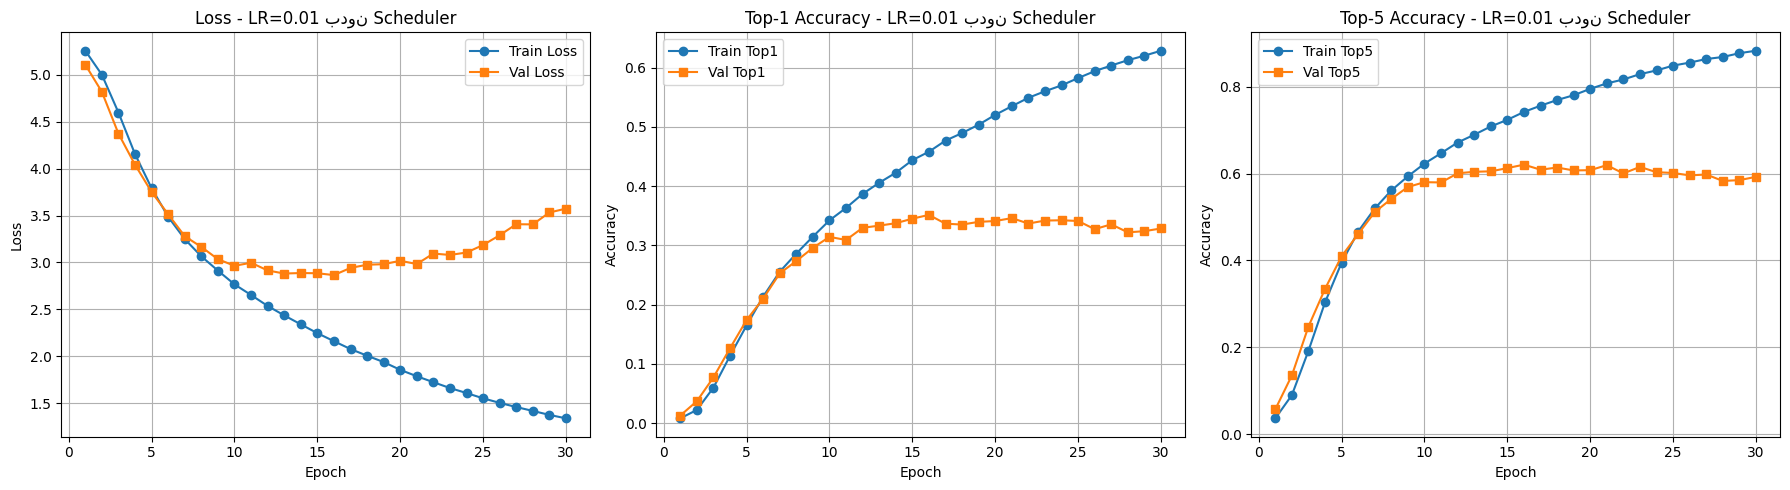

پ2: نرخ یادگیری 0.001 بدون Scheduler


Epoch 1/30 | Train Loss: 5.2989, Train Top1: 0.0049, Train Top5: 0.0242 | Val Loss: 5.2983, Val Top1: 0.0058, Val Top5: 0.0256


Epoch 2/30 | Train Loss: 5.2985, Train Top1: 0.0046, Train Top5: 0.0254 | Val Loss: 5.2980, Val Top1: 0.0059, Val Top5: 0.0269


Epoch 3/30 | Train Loss: 5.2982, Train Top1: 0.0048, Train Top5: 0.0257 | Val Loss: 5.2978, Val Top1: 0.0058, Val Top5: 0.0260


Epoch 4/30 | Train Loss: 5.2979, Train Top1: 0.0047, Train Top5: 0.0251 | Val Loss: 5.2974, Val Top1: 0.0059, Val Top5: 0.0274


Epoch 5/30 | Train Loss: 5.2974, Train Top1: 0.0049, Train Top5: 0.0255 | Val Loss: 5.2969, Val Top1: 0.0058, Val Top5: 0.0296


Epoch 6/30 | Train Loss: 5.2968, Train Top1: 0.0049, Train Top5: 0.0270 | Val Loss: 5.2961, Val Top1: 0.0064, Val Top5: 0.0289


Epoch 7/30 | Train Loss: 5.2957, Train Top1: 0.0070, Train Top5: 0.0297 | Val Loss: 5.2944, Val Top1: 0.0065, Val Top5: 0.0296


Epoch 8/30 | Train Loss: 5.2924, Train Top1: 0.0073, Train Top5: 0.0320 | Val Loss: 5.2872, Val Top1: 0.0081, Val Top5: 0.0356


Epoch 9/30 | Train Loss: 5.2283, Train Top1: 0.0113, Train Top5: 0.0479 | Val Loss: 5.1332, Val Top1: 0.0135, Val Top5: 0.0556


Epoch 10/30 | Train Loss: 5.0983, Train Top1: 0.0146, Train Top5: 0.0647 | Val Loss: 5.0668, Val Top1: 0.0173, Val Top5: 0.0717


Epoch 11/30 | Train Loss: 5.0460, Train Top1: 0.0208, Train Top5: 0.0834 | Val Loss: 5.0198, Val Top1: 0.0231, Val Top5: 0.0907


Epoch 12/30 | Train Loss: 4.9806, Train Top1: 0.0262, Train Top5: 0.1008 | Val Loss: 4.9275, Val Top1: 0.0282, Val Top5: 0.1159


Epoch 13/30 | Train Loss: 4.8791, Train Top1: 0.0351, Train Top5: 0.1256 | Val Loss: 4.8129, Val Top1: 0.0415, Val Top5: 0.1444


Epoch 14/30 | Train Loss: 4.7576, Train Top1: 0.0441, Train Top5: 0.1521 | Val Loss: 4.7278, Val Top1: 0.0452, Val Top5: 0.1585


Epoch 15/30 | Train Loss: 4.6651, Train Top1: 0.0534, Train Top5: 0.1758 | Val Loss: 4.6139, Val Top1: 0.0580, Val Top5: 0.1906


Epoch 16/30 | Train Loss: 4.5544, Train Top1: 0.0673, Train Top5: 0.2052 | Val Loss: 4.4899, Val Top1: 0.0792, Val Top5: 0.2239


Epoch 17/30 | Train Loss: 4.4174, Train Top1: 0.0854, Train Top5: 0.2423 | Val Loss: 4.3475, Val Top1: 0.0918, Val Top5: 0.2603


Epoch 18/30 | Train Loss: 4.2763, Train Top1: 0.1028, Train Top5: 0.2783 | Val Loss: 4.2914, Val Top1: 0.0964, Val Top5: 0.2788


Epoch 19/30 | Train Loss: 4.1514, Train Top1: 0.1201, Train Top5: 0.3102 | Val Loss: 4.1290, Val Top1: 0.1247, Val Top5: 0.3176


Epoch 20/30 | Train Loss: 4.0220, Train Top1: 0.1398, Train Top5: 0.3441 | Val Loss: 3.9771, Val Top1: 0.1479, Val Top5: 0.3611


Epoch 21/30 | Train Loss: 3.9019, Train Top1: 0.1578, Train Top5: 0.3725 | Val Loss: 3.9442, Val Top1: 0.1511, Val Top5: 0.3641


Epoch 22/30 | Train Loss: 3.7889, Train Top1: 0.1751, Train Top5: 0.4009 | Val Loss: 3.8748, Val Top1: 0.1677, Val Top5: 0.3822


Epoch 23/30 | Train Loss: 3.6940, Train Top1: 0.1888, Train Top5: 0.4243 | Val Loss: 3.7308, Val Top1: 0.1853, Val Top5: 0.4168


Epoch 24/30 | Train Loss: 3.6015, Train Top1: 0.2041, Train Top5: 0.4465 | Val Loss: 3.7126, Val Top1: 0.1852, Val Top5: 0.4215


Epoch 25/30 | Train Loss: 3.5201, Train Top1: 0.2182, Train Top5: 0.4641 | Val Loss: 3.6439, Val Top1: 0.2007, Val Top5: 0.4426


Epoch 26/30 | Train Loss: 3.4467, Train Top1: 0.2301, Train Top5: 0.4802 | Val Loss: 3.5865, Val Top1: 0.2054, Val Top5: 0.4512


Epoch 27/30 | Train Loss: 3.3690, Train Top1: 0.2432, Train Top5: 0.4982 | Val Loss: 3.5831, Val Top1: 0.2141, Val Top5: 0.4508


Epoch 28/30 | Train Loss: 3.3024, Train Top1: 0.2537, Train Top5: 0.5127 | Val Loss: 3.4625, Val Top1: 0.2305, Val Top5: 0.4790


Epoch 29/30 | Train Loss: 3.2322, Train Top1: 0.2648, Train Top5: 0.5269 | Val Loss: 3.4251, Val Top1: 0.2349, Val Top5: 0.4868


Epoch 30/30 | Train Loss: 3.1723, Train Top1: 0.2772, Train Top5: 0.5405 | Val Loss: 3.3722, Val Top1: 0.2485, Val Top5: 0.5008


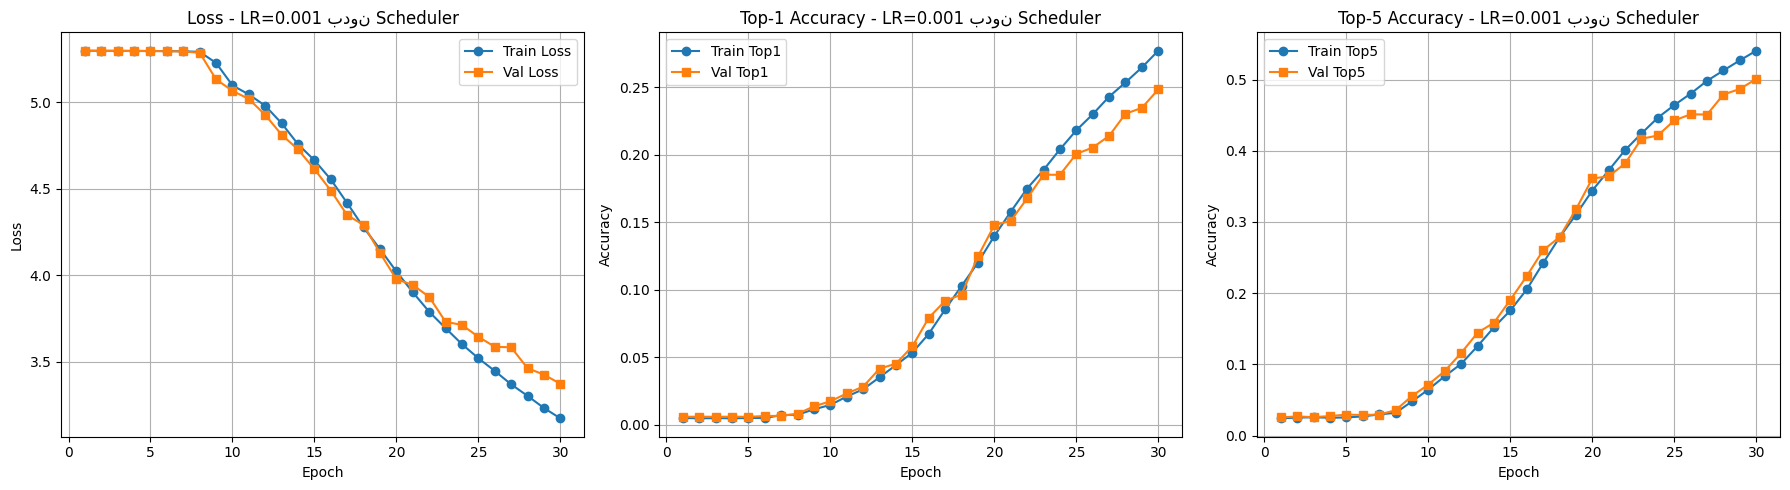

پ3: نرخ یادگیری 0.01 با Scheduler


Epoch 1/30 | Train Loss: 5.2883, Train Top1: 0.0058, Train Top5: 0.0299 | Val Loss: 5.1707, Val Top1: 0.0108, Val Top5: 0.0477


Epoch 2/30 | Train Loss: 5.0548, Train Top1: 0.0172, Train Top5: 0.0745 | Val Loss: 4.9264, Val Top1: 0.0246, Val Top5: 0.1055


Epoch 3/30 | Train Loss: 4.6928, Train Top1: 0.0475, Train Top5: 0.1634 | Val Loss: 4.5430, Val Top1: 0.0617, Val Top5: 0.2128


Epoch 4/30 | Train Loss: 4.2621, Train Top1: 0.0980, Train Top5: 0.2736 | Val Loss: 4.1930, Val Top1: 0.1092, Val Top5: 0.2950


Epoch 5/30 | Train Loss: 3.8778, Train Top1: 0.1519, Train Top5: 0.3710 | Val Loss: 3.7091, Val Top1: 0.1751, Val Top5: 0.4114


Epoch 6/30 | Train Loss: 3.3820, Train Top1: 0.2352, Train Top5: 0.4893 | Val Loss: 3.4099, Val Top1: 0.2292, Val Top5: 0.4835


Epoch 7/30 | Train Loss: 3.2771, Train Top1: 0.2516, Train Top5: 0.5132 | Val Loss: 3.3377, Val Top1: 0.2449, Val Top5: 0.4987


Epoch 8/30 | Train Loss: 3.2074, Train Top1: 0.2636, Train Top5: 0.5291 | Val Loss: 3.2911, Val Top1: 0.2497, Val Top5: 0.5095


Epoch 9/30 | Train Loss: 3.1421, Train Top1: 0.2753, Train Top5: 0.5427 | Val Loss: 3.2412, Val Top1: 0.2613, Val Top5: 0.5182


Epoch 10/30 | Train Loss: 3.0812, Train Top1: 0.2862, Train Top5: 0.5565 | Val Loss: 3.2519, Val Top1: 0.2588, Val Top5: 0.5166


Epoch 11/30 | Train Loss: 2.9617, Train Top1: 0.3098, Train Top5: 0.5825 | Val Loss: 3.1338, Val Top1: 0.2809, Val Top5: 0.5428


Epoch 12/30 | Train Loss: 2.9441, Train Top1: 0.3126, Train Top5: 0.5866 | Val Loss: 3.1268, Val Top1: 0.2827, Val Top5: 0.5439


Epoch 13/30 | Train Loss: 2.9340, Train Top1: 0.3146, Train Top5: 0.5900 | Val Loss: 3.1180, Val Top1: 0.2859, Val Top5: 0.5474


Epoch 14/30 | Train Loss: 2.9244, Train Top1: 0.3164, Train Top5: 0.5906 | Val Loss: 3.1148, Val Top1: 0.2844, Val Top5: 0.5475


Epoch 15/30 | Train Loss: 2.9155, Train Top1: 0.3181, Train Top5: 0.5919 | Val Loss: 3.1089, Val Top1: 0.2891, Val Top5: 0.5484


Epoch 16/30 | Train Loss: 2.8981, Train Top1: 0.3213, Train Top5: 0.5971 | Val Loss: 3.1042, Val Top1: 0.2903, Val Top5: 0.5502


Epoch 17/30 | Train Loss: 2.8959, Train Top1: 0.3219, Train Top5: 0.5974 | Val Loss: 3.1028, Val Top1: 0.2901, Val Top5: 0.5496


Epoch 18/30 | Train Loss: 2.8948, Train Top1: 0.3219, Train Top5: 0.5977 | Val Loss: 3.1029, Val Top1: 0.2895, Val Top5: 0.5483


Epoch 19/30 | Train Loss: 2.8934, Train Top1: 0.3222, Train Top5: 0.5978 | Val Loss: 3.1014, Val Top1: 0.2906, Val Top5: 0.5488


Epoch 20/30 | Train Loss: 2.8926, Train Top1: 0.3220, Train Top5: 0.5978 | Val Loss: 3.1013, Val Top1: 0.2908, Val Top5: 0.5499


Epoch 21/30 | Train Loss: 2.8904, Train Top1: 0.3227, Train Top5: 0.5986 | Val Loss: 3.1008, Val Top1: 0.2913, Val Top5: 0.5494


Epoch 22/30 | Train Loss: 2.8902, Train Top1: 0.3227, Train Top5: 0.5987 | Val Loss: 3.1007, Val Top1: 0.2914, Val Top5: 0.5492


Epoch 23/30 | Train Loss: 2.8901, Train Top1: 0.3226, Train Top5: 0.5988 | Val Loss: 3.1007, Val Top1: 0.2911, Val Top5: 0.5490


Epoch 24/30 | Train Loss: 2.8900, Train Top1: 0.3227, Train Top5: 0.5991 | Val Loss: 3.1006, Val Top1: 0.2912, Val Top5: 0.5492


Epoch 25/30 | Train Loss: 2.8899, Train Top1: 0.3228, Train Top5: 0.5989 | Val Loss: 3.1006, Val Top1: 0.2914, Val Top5: 0.5489


Epoch 26/30 | Train Loss: 2.8896, Train Top1: 0.3228, Train Top5: 0.5989 | Val Loss: 3.1006, Val Top1: 0.2911, Val Top5: 0.5489


Epoch 27/30 | Train Loss: 2.8896, Train Top1: 0.3228, Train Top5: 0.5989 | Val Loss: 3.1006, Val Top1: 0.2910, Val Top5: 0.5488


Epoch 28/30 | Train Loss: 2.8896, Train Top1: 0.3227, Train Top5: 0.5990 | Val Loss: 3.1006, Val Top1: 0.2911, Val Top5: 0.5491


Epoch 29/30 | Train Loss: 2.8896, Train Top1: 0.3228, Train Top5: 0.5990 | Val Loss: 3.1005, Val Top1: 0.2913, Val Top5: 0.5492


Epoch 30/30 | Train Loss: 2.8896, Train Top1: 0.3227, Train Top5: 0.5990 | Val Loss: 3.1005, Val Top1: 0.2911, Val Top5: 0.5491


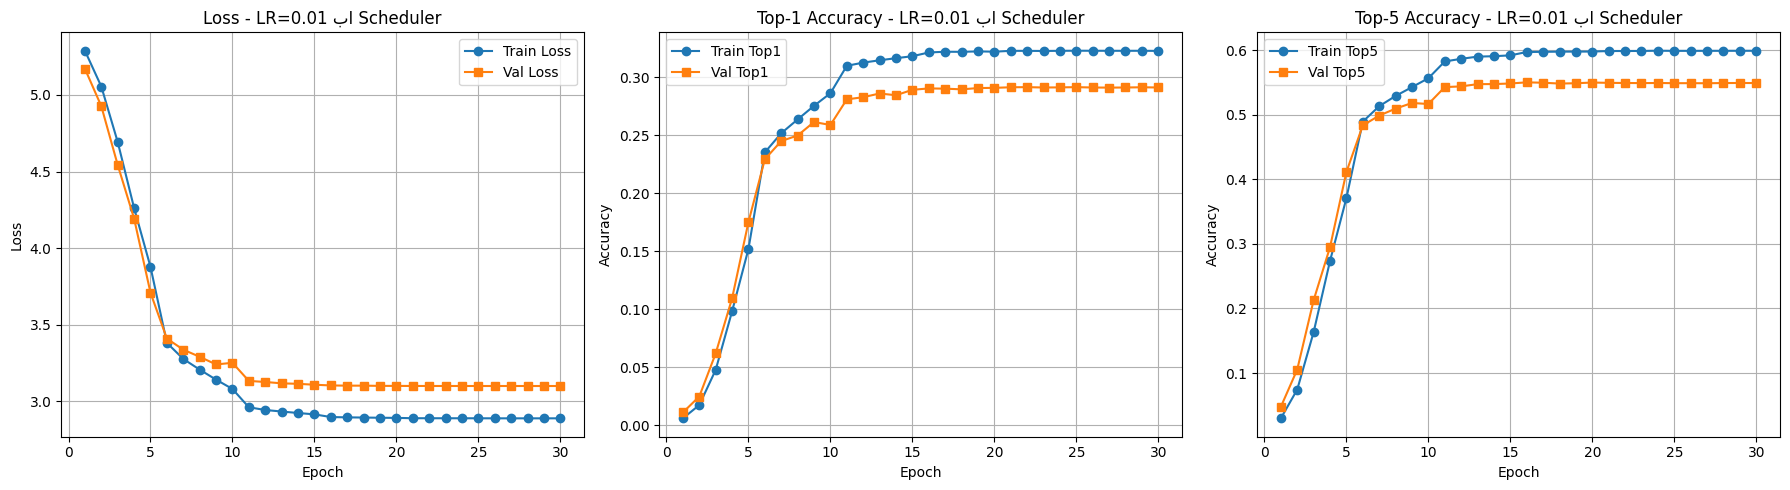

In [ ]:

print("بخش پ: بررسی تاثیر نرخ یادگیری")


print("پ1: نرخ یادگیری 0.01 بدون Scheduler")
model = ResIncepCNNBase(numClasses=len(trainDataset.classes)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
scheduler = None
criterion = nn.CrossEntropyLoss()
trainLossesP1, trainTop1P1, trainTop5P1, valLossesP1, valTop1P1, valTop5P1 = trainModel(model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30)
plotMetrics(trainLossesP1, trainTop1P1, trainTop5P1, valLossesP1, valTop1P1, valTop5P1, "LR=0.01 بدون Scheduler")

print("پ2: نرخ یادگیری 0.001 بدون Scheduler")
model = ResIncepCNNBase(numClasses=len(trainDataset.classes)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0)
scheduler = None
criterion = nn.CrossEntropyLoss()
trainLossesP2, trainTop1P2, trainTop5P2, valLossesP2, valTop1P2, valTop5P2 = trainModel(model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30)
plotMetrics(trainLossesP2, trainTop1P2, trainTop5P2, valLossesP2, valTop1P2, valTop5P2, "LR=0.001 بدون Scheduler")

print("پ3: نرخ یادگیری 0.01 با Scheduler")
model = ResIncepCNNBase(numClasses=len(trainDataset.classes)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()
trainLossesP3, trainTop1P3, trainTop5P3, valLossesP3, valTop1P3, valTop5P3 = trainModel(model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30)
plotMetrics(trainLossesP3, trainTop1P3, trainTop5P3, valLossesP3, valTop1P3, valTop5P3, "LR=0.01 با Scheduler")



In [ ]:
weightDecayValues = [0.2, 0.4, 0.6, 0.8, 1.0]  
bestLearningRate = 0.01

resultsT = {}

for wd in weightDecayValues:
    print(f"ت: ضریب رگولاسیون = {wd:.1f}")
    model = ResIncepCNNBase(numClasses=len(trainDataset.classes)).to(device)
    optimizer = optim.SGD(model.parameters(), lr=bestLearningRate, momentum=0.9, weight_decay=wd)
    scheduler = None
    criterion = nn.CrossEntropyLoss()
    trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5 = trainModel(
        model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30)
    resultsT[wd] = (trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5)
    plotMetrics(trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5, f"WD={wd:.1f}")


ت: ضریب رگولاسیون = 0.2


Epoch 1/30 | Train Loss: 5.2984, Train Top1: 0.0046, Train Top5: 0.0247 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 2/30 | Train Loss: 5.2984, Train Top1: 0.0048, Train Top5: 0.0242 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 3/30 | Train Loss: 5.2984, Train Top1: 0.0051, Train Top5: 0.0244 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 4/30 | Train Loss: 5.2984, Train Top1: 0.0054, Train Top5: 0.0240 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 5/30 | Train Loss: 5.2984, Train Top1: 0.0051, Train Top5: 0.0246 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 6/30 | Train Loss: 5.2984, Train Top1: 0.0052, Train Top5: 0.0247 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 7/30 | Train Loss: 5.2984, Train Top1: 0.0050, Train Top5: 0.0245 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 8/30 | Train Loss: 5.2984, Train Top1: 0.0049, Train Top5: 0.0248 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 9/30 | Train Loss: 5.2984, Train Top1: 0.0045, Train Top5: 0.0238 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 10/30 | Train Loss: 5.2984, Train Top1: 0.0048, Train Top5: 0.0238 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 11/30 | Train Loss: 5.2984, Train Top1: 0.0049, Train Top5: 0.0242 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 12/30 | Train Loss: 5.2984, Train Top1: 0.0048, Train Top5: 0.0244 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 13/30 | Train Loss: 5.2984, Train Top1: 0.0048, Train Top5: 0.0238 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 14/30 | Train Loss: 5.2984, Train Top1: 0.0048, Train Top5: 0.0250 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 15/30 | Train Loss: 5.2984, Train Top1: 0.0051, Train Top5: 0.0247 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 16/30 | Train Loss: 5.2984, Train Top1: 0.0048, Train Top5: 0.0249 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 17/30 | Train Loss: 5.2984, Train Top1: 0.0051, Train Top5: 0.0243 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 18/30 | Train Loss: 5.2984, Train Top1: 0.0050, Train Top5: 0.0245 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 19/30 | Train Loss: 5.2984, Train Top1: 0.0049, Train Top5: 0.0239 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 20/30 | Train Loss: 5.2984, Train Top1: 0.0050, Train Top5: 0.0246 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 21/30 | Train Loss: 5.2984, Train Top1: 0.0049, Train Top5: 0.0248 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 22/30 | Train Loss: 5.2984, Train Top1: 0.0049, Train Top5: 0.0239 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 23/30 | Train Loss: 5.2984, Train Top1: 0.0044, Train Top5: 0.0229 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 24/30 | Train Loss: 5.2984, Train Top1: 0.0048, Train Top5: 0.0248 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


KeyboardInterrupt: 

ت: ضریب رگولاسیون = 0.0


Epoch 1/30 | Train Loss: 5.2993, Train Top1: 0.0045, Train Top5: 0.0234 | Val Loss: 5.2980, Val Top1: 0.0057, Val Top5: 0.0252


Epoch 2/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0230 | Val Loss: 5.2982, Val Top1: 0.0050, Val Top5: 0.0272


Epoch 3/30 | Train Loss: 5.2990, Train Top1: 0.0044, Train Top5: 0.0230 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 4/30 | Train Loss: 5.2990, Train Top1: 0.0042, Train Top5: 0.0222 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 5/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0224 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 6/30 | Train Loss: 5.2990, Train Top1: 0.0042, Train Top5: 0.0215 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 7/30 | Train Loss: 5.2990, Train Top1: 0.0043, Train Top5: 0.0222 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 8/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0225 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 9/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0230 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 10/30 | Train Loss: 5.2989, Train Top1: 0.0041, Train Top5: 0.0222 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 11/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0222 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 12/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 13/30 | Train Loss: 5.2990, Train Top1: 0.0043, Train Top5: 0.0221 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 14/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0218 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 15/30 | Train Loss: 5.2990, Train Top1: 0.0041, Train Top5: 0.0224 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 16/30 | Train Loss: 5.2990, Train Top1: 0.0043, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 17/30 | Train Loss: 5.2990, Train Top1: 0.0043, Train Top5: 0.0227 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 18/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0219 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 19/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 20/30 | Train Loss: 5.2989, Train Top1: 0.0041, Train Top5: 0.0223 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 21/30 | Train Loss: 5.2990, Train Top1: 0.0043, Train Top5: 0.0227 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 22/30 | Train Loss: 5.2990, Train Top1: 0.0042, Train Top5: 0.0216 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 23/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 24/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0217 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 25/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0230 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 26/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0233 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 27/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0222 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 28/30 | Train Loss: 5.2990, Train Top1: 0.0040, Train Top5: 0.0219 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 29/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0221 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 30/30 | Train Loss: 5.2990, Train Top1: 0.0046, Train Top5: 0.0223 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


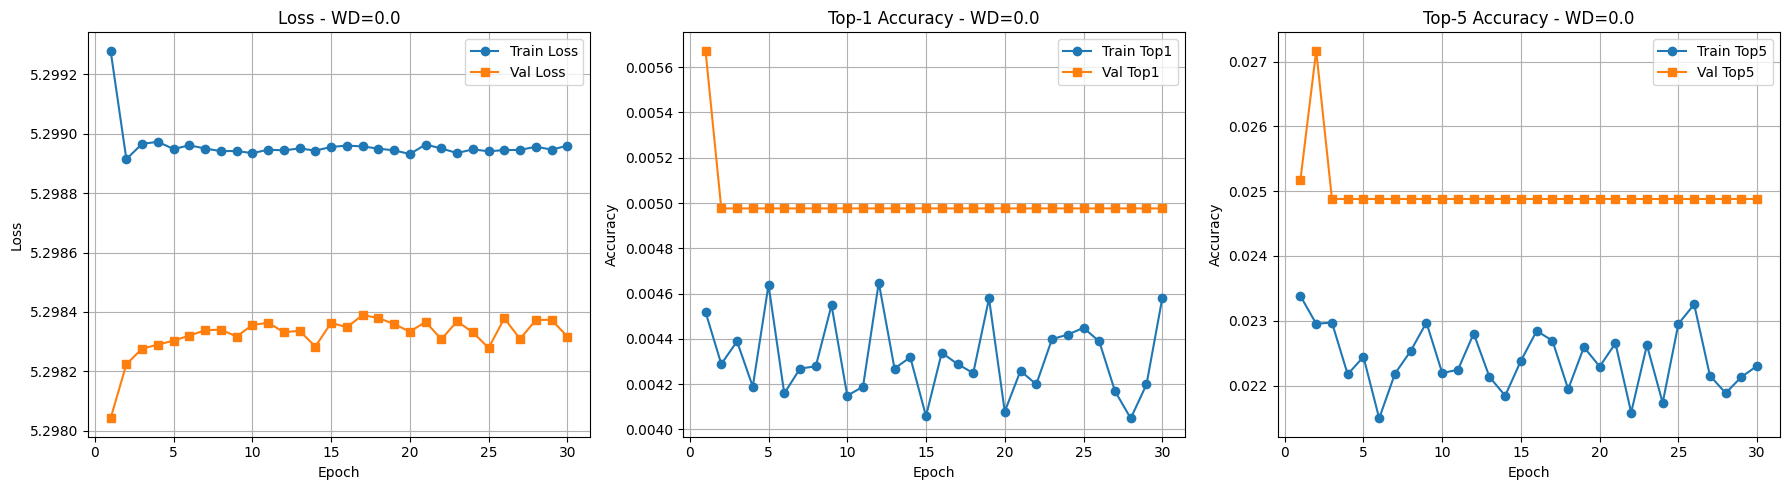

ت: ضریب رگولاسیون = 0.0


Epoch 1/30 | Train Loss: 5.2993, Train Top1: 0.0046, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 2/30 | Train Loss: 5.2990, Train Top1: 0.0043, Train Top5: 0.0216 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 3/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0218 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 4/30 | Train Loss: 5.2989, Train Top1: 0.0047, Train Top5: 0.0223 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 5/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0224 | Val Loss: 5.2985, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 6/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0225 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 7/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 8/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 9/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 10/30 | Train Loss: 5.2989, Train Top1: 0.0041, Train Top5: 0.0218 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 11/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0223 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 12/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 13/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0221 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 14/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0225 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 15/30 | Train Loss: 5.2989, Train Top1: 0.0041, Train Top5: 0.0225 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 16/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 17/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 18/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0216 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 19/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 20/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0230 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 21/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0223 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 22/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 23/30 | Train Loss: 5.2989, Train Top1: 0.0047, Train Top5: 0.0222 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 24/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0221 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 25/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 26/30 | Train Loss: 5.2989, Train Top1: 0.0049, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 27/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0225 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 28/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0218 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 29/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0222 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 30/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0223 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


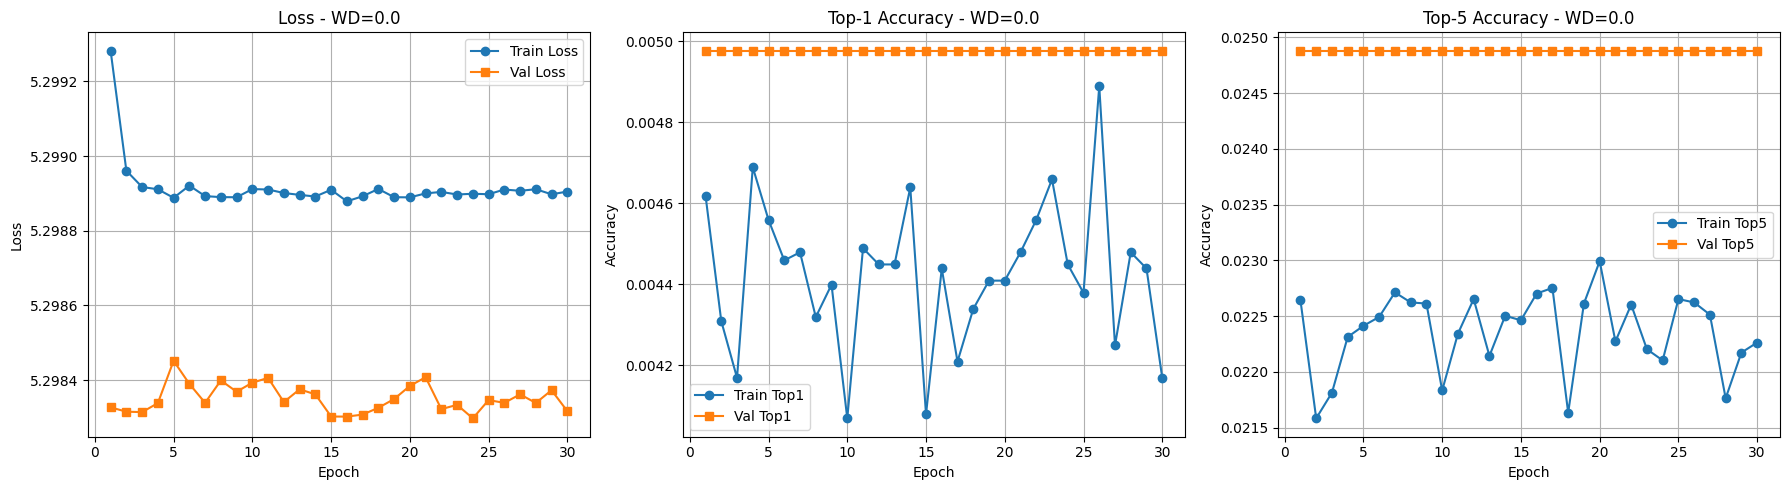

ت: ضریب رگولاسیون = 0.0


Epoch 1/30 | Train Loss: 5.2991, Train Top1: 0.0041, Train Top5: 0.0232 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 2/30 | Train Loss: 5.2989, Train Top1: 0.0040, Train Top5: 0.0228 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 3/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0225 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 4/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 5/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0227 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 6/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 7/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 8/30 | Train Loss: 5.2989, Train Top1: 0.0047, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 9/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 10/30 | Train Loss: 5.2988, Train Top1: 0.0044, Train Top5: 0.0231 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 11/30 | Train Loss: 5.2989, Train Top1: 0.0047, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 12/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 13/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0235 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 14/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0220 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 15/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0220 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0297


Epoch 16/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0229 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 17/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0225 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 18/30 | Train Loss: 5.2989, Train Top1: 0.0046, Train Top5: 0.0229 | Val Loss: 5.2985, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 19/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0236 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 20/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0225 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 21/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0231 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 22/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0229 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 23/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0232 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 24/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0223 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 25/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 26/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0223 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 27/30 | Train Loss: 5.2989, Train Top1: 0.0042, Train Top5: 0.0216 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 28/30 | Train Loss: 5.2989, Train Top1: 0.0045, Train Top5: 0.0228 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 29/30 | Train Loss: 5.2989, Train Top1: 0.0044, Train Top5: 0.0229 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 30/30 | Train Loss: 5.2989, Train Top1: 0.0043, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


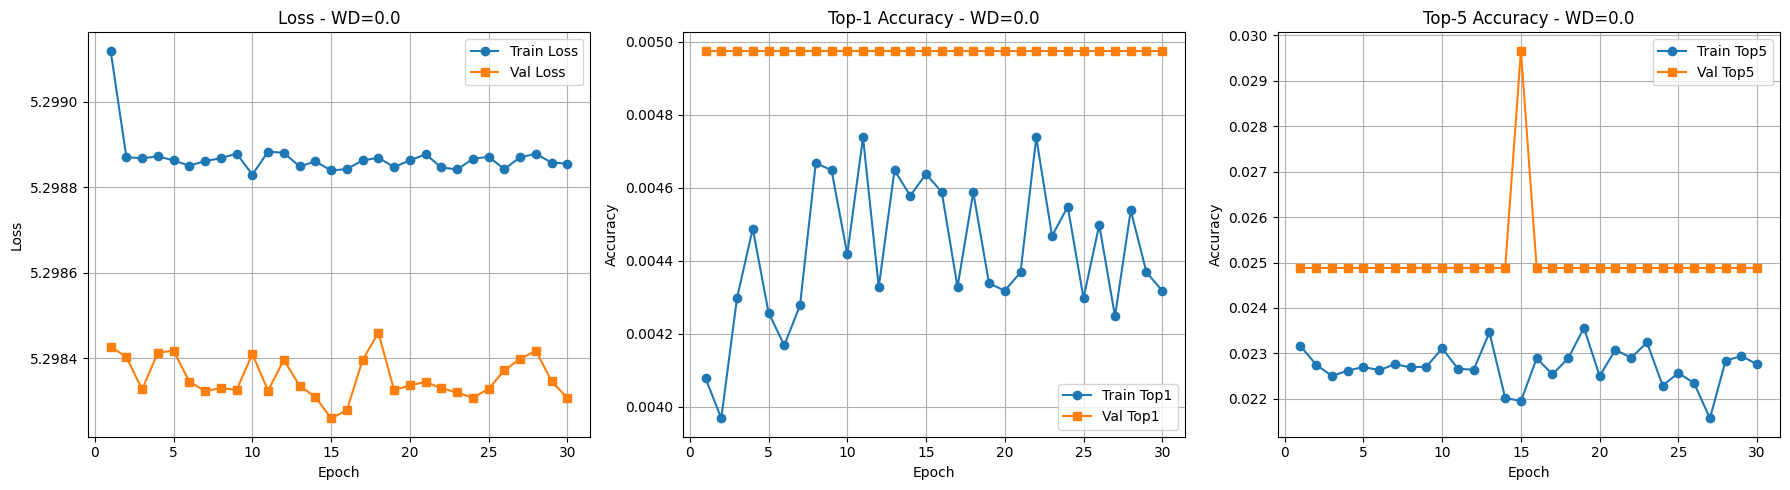

ت: ضریب رگولاسیون = 0.0


Epoch 1/30 | Train Loss: 5.2991, Train Top1: 0.0045, Train Top5: 0.0225 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 2/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 3/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0229 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 4/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 5/30 | Train Loss: 5.2988, Train Top1: 0.0048, Train Top5: 0.0234 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 6/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0232 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 7/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0232 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 8/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0233 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 9/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0229 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 10/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0232 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 11/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0223 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 12/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0230 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 13/30 | Train Loss: 5.2988, Train Top1: 0.0044, Train Top5: 0.0229 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 14/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 15/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 16/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 17/30 | Train Loss: 5.2988, Train Top1: 0.0044, Train Top5: 0.0222 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 18/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 19/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0232 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 20/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0232 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 21/30 | Train Loss: 5.2988, Train Top1: 0.0044, Train Top5: 0.0229 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 22/30 | Train Loss: 5.2988, Train Top1: 0.0041, Train Top5: 0.0228 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 23/30 | Train Loss: 5.2988, Train Top1: 0.0044, Train Top5: 0.0218 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 24/30 | Train Loss: 5.2988, Train Top1: 0.0048, Train Top5: 0.0232 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 25/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 26/30 | Train Loss: 5.2988, Train Top1: 0.0044, Train Top5: 0.0226 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 27/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 28/30 | Train Loss: 5.2988, Train Top1: 0.0041, Train Top5: 0.0230 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 29/30 | Train Loss: 5.2988, Train Top1: 0.0042, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 30/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0223 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


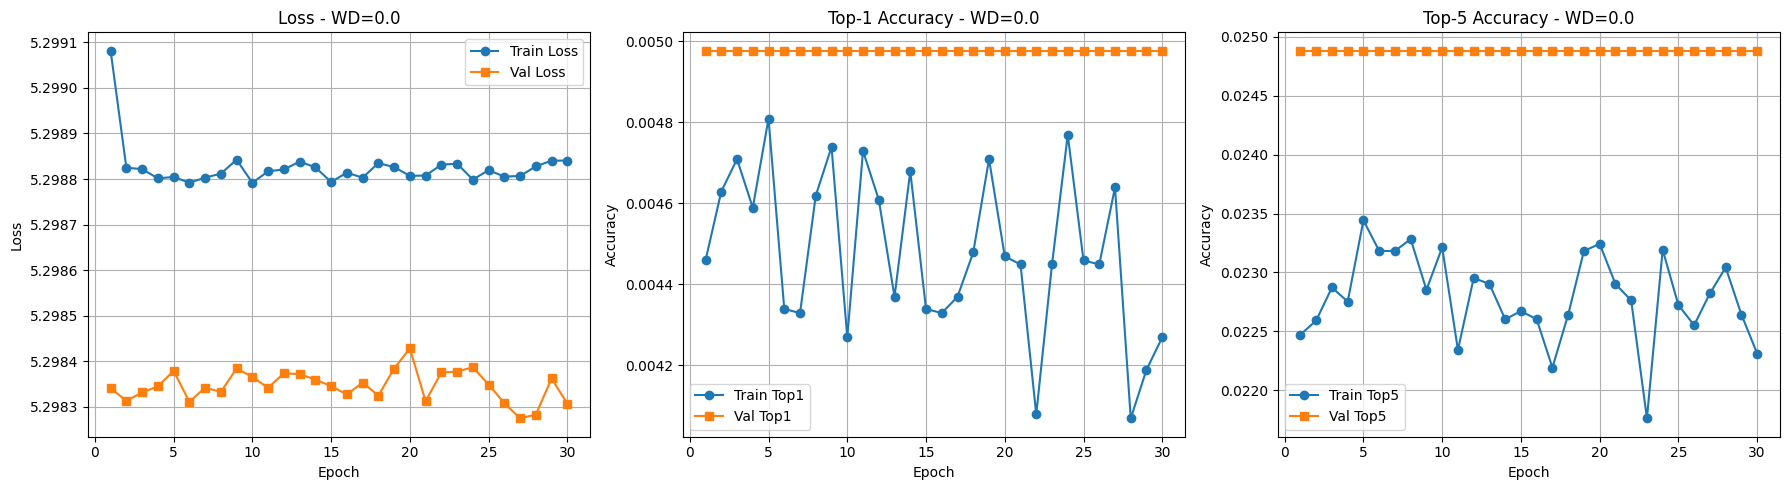

ت: ضریب رگولاسیون = 0.0


Epoch 1/30 | Train Loss: 5.2990, Train Top1: 0.0043, Train Top5: 0.0222 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 2/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0230 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 3/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0234 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 4/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0238 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 5/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0226 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 6/30 | Train Loss: 5.2988, Train Top1: 0.0047, Train Top5: 0.0227 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 7/30 | Train Loss: 5.2988, Train Top1: 0.0042, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 8/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0225 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 9/30 | Train Loss: 5.2988, Train Top1: 0.0044, Train Top5: 0.0223 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 10/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 11/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0228 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 12/30 | Train Loss: 5.2988, Train Top1: 0.0043, Train Top5: 0.0229 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 13/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0225 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 14/30 | Train Loss: 5.2988, Train Top1: 0.0046, Train Top5: 0.0236 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 15/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0225 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 16/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0230 | Val Loss: 5.2983, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 17/30 | Train Loss: 5.2988, Train Top1: 0.0045, Train Top5: 0.0233 | Val Loss: 5.2984, Val Top1: 0.0050, Val Top5: 0.0249


Epoch 18/30 | Train Loss: 5.2988, Train Top1: 0.0039, Train Top5: 0.0224 | Val Loss: 5.2982, Val Top1: 0.0098, Val Top5: 0.0297


Epoch 19/30:  49%|████▉     | 770/1563 [00:40<00:39, 19.92it/s]

In [ ]:
weightDecayValues = [0.002, 0.004, 0.006, 0.008 ,0.01] 
bestLearningRate = 0.01

resultsT = {}

for wd in weightDecayValues:
    print(f"ت: ضریب رگولاسیون = {wd:.1f}")
    model = ResIncepCNNBase(numClasses=len(trainDataset.classes)).to(device)
    optimizer = optim.SGD(model.parameters(), lr=bestLearningRate, momentum=0.9, weight_decay=wd)
    scheduler = None
    criterion = nn.CrossEntropyLoss()
    trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5 = trainModel(
        model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30)
    resultsT[wd] = (trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5)
    plotMetrics(trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5, f"WD={wd:.1f}")



=== بخش ث: بررسی تاثیر Dropout و Batch Normalization ===

ث: مدل با Dropout و BatchNorm


Epoch 1/30 | Train Loss: 4.7514, Train Top1: 0.0471, Train Top5: 0.1589 | Val Loss: 10.4178, Val Top1: 0.0066, Val Top5: 0.0656


Epoch 2/30 | Train Loss: 4.1617, Train Top1: 0.1119, Train Top5: 0.3060 | Val Loss: 4.9348, Val Top1: 0.0655, Val Top5: 0.1989


Epoch 3/30 | Train Loss: 3.9037, Train Top1: 0.1447, Train Top5: 0.3679 | Val Loss: 5.0850, Val Top1: 0.0810, Val Top5: 0.2213


Epoch 4/30 | Train Loss: 3.7520, Train Top1: 0.1683, Train Top5: 0.4056 | Val Loss: 3.9354, Val Top1: 0.1295, Val Top5: 0.3585


Epoch 5/30 | Train Loss: 3.6446, Train Top1: 0.1837, Train Top5: 0.4297 | Val Loss: 4.0184, Val Top1: 0.1326, Val Top5: 0.3519


Epoch 6/30 | Train Loss: 3.4346, Train Top1: 0.2229, Train Top5: 0.4795 | Val Loss: 3.3216, Val Top1: 0.2425, Val Top5: 0.5050


Epoch 7/30 | Train Loss: 3.3842, Train Top1: 0.2287, Train Top5: 0.4925 | Val Loss: 3.2806, Val Top1: 0.2463, Val Top5: 0.5140


Epoch 8/30 | Train Loss: 3.3606, Train Top1: 0.2345, Train Top5: 0.4960 | Val Loss: 3.3313, Val Top1: 0.2386, Val Top5: 0.5006


Epoch 9/30 | Train Loss: 3.3376, Train Top1: 0.2371, Train Top5: 0.5018 | Val Loss: 3.3921, Val Top1: 0.2377, Val Top5: 0.4882


Epoch 10/30 | Train Loss: 3.3120, Train Top1: 0.2416, Train Top5: 0.5083 | Val Loss: 3.2240, Val Top1: 0.2590, Val Top5: 0.5257


Epoch 11/30 | Train Loss: 3.2764, Train Top1: 0.2494, Train Top5: 0.5157 | Val Loss: 3.1919, Val Top1: 0.2643, Val Top5: 0.5330


Epoch 12/30 | Train Loss: 3.2694, Train Top1: 0.2493, Train Top5: 0.5178 | Val Loss: 3.1888, Val Top1: 0.2640, Val Top5: 0.5336


Epoch 13/30 | Train Loss: 3.2714, Train Top1: 0.2488, Train Top5: 0.5162 | Val Loss: 3.1832, Val Top1: 0.2648, Val Top5: 0.5338


Epoch 14/30 | Train Loss: 3.2664, Train Top1: 0.2493, Train Top5: 0.5178 | Val Loss: 3.1803, Val Top1: 0.2650, Val Top5: 0.5354


Epoch 15/30 | Train Loss: 3.2642, Train Top1: 0.2515, Train Top5: 0.5168 | Val Loss: 3.1822, Val Top1: 0.2653, Val Top5: 0.5355


Epoch 16/30 | Train Loss: 3.2578, Train Top1: 0.2532, Train Top5: 0.5196 | Val Loss: 3.1841, Val Top1: 0.2660, Val Top5: 0.5353


Epoch 17/30 | Train Loss: 3.2549, Train Top1: 0.2521, Train Top5: 0.5205 | Val Loss: 3.1785, Val Top1: 0.2659, Val Top5: 0.5345


Epoch 18/30 | Train Loss: 3.2574, Train Top1: 0.2536, Train Top5: 0.5191 | Val Loss: 3.1801, Val Top1: 0.2658, Val Top5: 0.5350


Epoch 19/30 | Train Loss: 3.2572, Train Top1: 0.2513, Train Top5: 0.5214 | Val Loss: 3.1749, Val Top1: 0.2669, Val Top5: 0.5349


Epoch 20/30 | Train Loss: 3.2574, Train Top1: 0.2506, Train Top5: 0.5200 | Val Loss: 3.1784, Val Top1: 0.2665, Val Top5: 0.5359


Epoch 21/30 | Train Loss: 3.2578, Train Top1: 0.2514, Train Top5: 0.5214 | Val Loss: 3.1786, Val Top1: 0.2652, Val Top5: 0.5360


Epoch 22/30 | Train Loss: 3.2547, Train Top1: 0.2522, Train Top5: 0.5210 | Val Loss: 3.1803, Val Top1: 0.2663, Val Top5: 0.5352


Epoch 23/30 | Train Loss: 3.2549, Train Top1: 0.2521, Train Top5: 0.5199 | Val Loss: 3.1772, Val Top1: 0.2640, Val Top5: 0.5364


Epoch 24/30 | Train Loss: 3.2579, Train Top1: 0.2507, Train Top5: 0.5206 | Val Loss: 3.1768, Val Top1: 0.2655, Val Top5: 0.5368


Epoch 25/30 | Train Loss: 3.2539, Train Top1: 0.2530, Train Top5: 0.5217 | Val Loss: 3.1797, Val Top1: 0.2655, Val Top5: 0.5366


Epoch 26/30 | Train Loss: 3.2570, Train Top1: 0.2526, Train Top5: 0.5206 | Val Loss: 3.1770, Val Top1: 0.2665, Val Top5: 0.5354


Epoch 27/30 | Train Loss: 3.2526, Train Top1: 0.2544, Train Top5: 0.5214 | Val Loss: 3.1777, Val Top1: 0.2652, Val Top5: 0.5357


Epoch 28/30 | Train Loss: 3.2563, Train Top1: 0.2517, Train Top5: 0.5197 | Val Loss: 3.1772, Val Top1: 0.2656, Val Top5: 0.5373


Epoch 29/30 | Train Loss: 3.2539, Train Top1: 0.2515, Train Top5: 0.5217 | Val Loss: 3.1780, Val Top1: 0.2647, Val Top5: 0.5353


Epoch 30/30 | Train Loss: 3.2576, Train Top1: 0.2522, Train Top5: 0.5197 | Val Loss: 3.1783, Val Top1: 0.2673, Val Top5: 0.5367


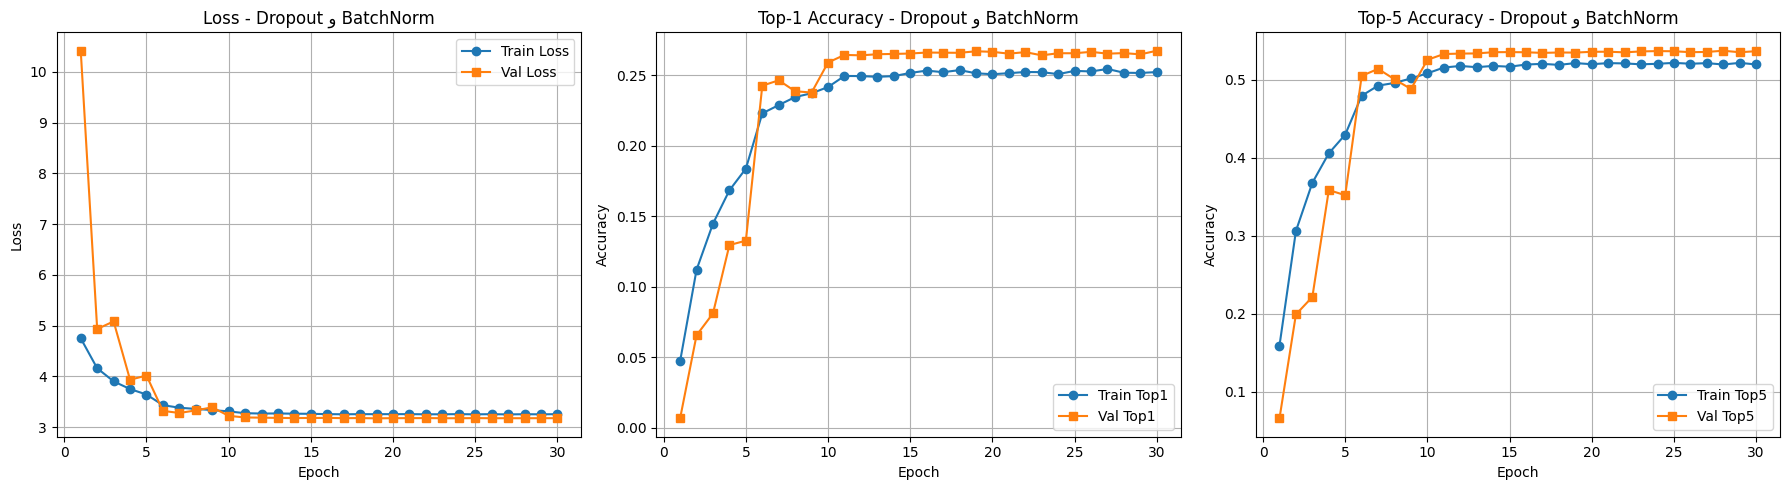

In [ ]:
bestWeightDecay = 0.0
bestLearningRate = 0.01
print("\n=== بخش ث: بررسی تاثیر Dropout و Batch Normalization ===\n")

print("ث: مدل با Dropout و BatchNorm")
model = ResIncepCNNWithBNDropout(numClasses=len(trainDataset.classes), dropoutProb=0.5).to(device)
optimizer = optim.SGD(model.parameters(), lr=bestLearningRate, momentum=0.9, weight_decay=bestWeightDecay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()
trainLossesBN, trainTop1BN, trainTop5BN, valLossesBN, valTop1BN, valTop5BN = trainModel(model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30)
plotMetrics(trainLossesBN, trainTop1BN, trainTop5BN, valLossesBN, valTop1BN, valTop5BN, "Dropout و BatchNorm")

# **مدل جدید با نورمالیز کردن بخش های کانولوشنی**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
class InceptionBlockBN(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(InceptionBlockBN, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.branch5 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, kernel_size=5, padding=2),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.branchPool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(inChannels, outChannels * 4, kernel_size=1),
            nn.BatchNorm2d(outChannels * 4)
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out1 = self.branch1(x)    
        out3 = self.branch3(x)
        out5 = self.branch5(x)
        outPool = self.branchPool(x)
        out = torch.cat([out1, out3, out5, outPool], dim=1) 
        return F.relu(out + residual)
class ResidualBlockBN(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(ResidualBlockBN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outChannels)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels)
        )

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)      
        out = self.conv2(out)   
        return F.relu(out + identity)
class ResIncepCNNWithBNDropout_All(nn.Module):
    def __init__(self, numClasses=200, dropoutProb=0.5):
        super(ResIncepCNNWithBNDropout_All, self).__init__()
 
        self.block1 = InceptionBlockBN(3, 16)     
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block2 = ResidualBlockBN(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block3 = InceptionBlockBN(128, 32)   
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block4 = ResidualBlockBN(128, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.globalPool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128, 512)
        self.bnFc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(p=dropoutProb)
        self.fc2 = nn.Linear(512, numClasses)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)

        x = self.block2(x)
        x = self.pool2(x)

        x = self.block3(x)
        x = self.pool3(x)

        x = self.block4(x)
        x = self.pool4(x)

        x = self.globalPool(x)   
        x = self.flatten(x)    

        x = self.fc1(x)         
        x = self.bnFc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)        
        return x



=== بخش ث: بررسی تاثیر Dropout و Batch Normalization ===

ث: مدل با Dropout و BatchNorm


Epoch 1/30 | Train Loss: 4.3029, Train Top1: 0.0987, Train Top5: 0.2727 | Val Loss: 3.9298, Val Top1: 0.1388, Val Top5: 0.3627


Epoch 2/30 | Train Loss: 3.5709, Train Top1: 0.1958, Train Top5: 0.4465 | Val Loss: 3.3518, Val Top1: 0.2304, Val Top5: 0.4992


Epoch 3/30 | Train Loss: 3.2391, Train Top1: 0.2499, Train Top5: 0.5247 | Val Loss: 3.1137, Val Top1: 0.2815, Val Top5: 0.5506


Epoch 4/30 | Train Loss: 3.0294, Train Top1: 0.2890, Train Top5: 0.5701 | Val Loss: 2.9909, Val Top1: 0.3046, Val Top5: 0.5670


Epoch 5/30 | Train Loss: 2.8614, Train Top1: 0.3206, Train Top5: 0.6064 | Val Loss: 2.7564, Val Top1: 0.3479, Val Top5: 0.6250


Epoch 6/30 | Train Loss: 2.5352, Train Top1: 0.3862, Train Top5: 0.6722 | Val Loss: 2.5176, Val Top1: 0.3994, Val Top5: 0.6731


Epoch 7/30 | Train Loss: 2.4580, Train Top1: 0.4035, Train Top5: 0.6892 | Val Loss: 2.4829, Val Top1: 0.4034, Val Top5: 0.6827


Epoch 8/30 | Train Loss: 2.4074, Train Top1: 0.4114, Train Top5: 0.6987 | Val Loss: 2.4694, Val Top1: 0.4083, Val Top5: 0.6857


Epoch 9/30 | Train Loss: 2.3696, Train Top1: 0.4196, Train Top5: 0.7052 | Val Loss: 2.4540, Val Top1: 0.4111, Val Top5: 0.6842


Epoch 10/30 | Train Loss: 2.3400, Train Top1: 0.4254, Train Top5: 0.7107 | Val Loss: 2.4439, Val Top1: 0.4134, Val Top5: 0.6883


Epoch 11/30 | Train Loss: 2.2705, Train Top1: 0.4413, Train Top5: 0.7239 | Val Loss: 2.4138, Val Top1: 0.4182, Val Top5: 0.6934


Epoch 12/30 | Train Loss: 2.2647, Train Top1: 0.4421, Train Top5: 0.7255 | Val Loss: 2.4119, Val Top1: 0.4189, Val Top5: 0.6959


Epoch 13/30 | Train Loss: 2.2579, Train Top1: 0.4426, Train Top5: 0.7253 | Val Loss: 2.4120, Val Top1: 0.4196, Val Top5: 0.6931


Epoch 14/30 | Train Loss: 2.2492, Train Top1: 0.4459, Train Top5: 0.7275 | Val Loss: 2.4094, Val Top1: 0.4202, Val Top5: 0.6956


Epoch 15/30 | Train Loss: 2.2488, Train Top1: 0.4450, Train Top5: 0.7282 | Val Loss: 2.4088, Val Top1: 0.4220, Val Top5: 0.6944


Epoch 16/30 | Train Loss: 2.2358, Train Top1: 0.4492, Train Top5: 0.7305 | Val Loss: 2.4078, Val Top1: 0.4227, Val Top5: 0.6942


Epoch 17/30 | Train Loss: 2.2306, Train Top1: 0.4499, Train Top5: 0.7307 | Val Loss: 2.4072, Val Top1: 0.4208, Val Top5: 0.6954


Epoch 18/30 | Train Loss: 2.2380, Train Top1: 0.4487, Train Top5: 0.7296 | Val Loss: 2.4064, Val Top1: 0.4224, Val Top5: 0.6939


Epoch 19/30 | Train Loss: 2.2404, Train Top1: 0.4464, Train Top5: 0.7295 | Val Loss: 2.4075, Val Top1: 0.4210, Val Top5: 0.6950


Epoch 20/30 | Train Loss: 2.2299, Train Top1: 0.4492, Train Top5: 0.7322 | Val Loss: 2.4056, Val Top1: 0.4206, Val Top5: 0.6942


Epoch 21/30 | Train Loss: 2.2333, Train Top1: 0.4481, Train Top5: 0.7309 | Val Loss: 2.4062, Val Top1: 0.4205, Val Top5: 0.6963


Epoch 22/30 | Train Loss: 2.2364, Train Top1: 0.4474, Train Top5: 0.7320 | Val Loss: 2.4075, Val Top1: 0.4201, Val Top5: 0.6930


Epoch 23/30 | Train Loss: 2.2327, Train Top1: 0.4503, Train Top5: 0.7309 | Val Loss: 2.4055, Val Top1: 0.4206, Val Top5: 0.6955


Epoch 24/30 | Train Loss: 2.2318, Train Top1: 0.4495, Train Top5: 0.7302 | Val Loss: 2.4072, Val Top1: 0.4175, Val Top5: 0.6941


Epoch 25/30 | Train Loss: 2.2372, Train Top1: 0.4476, Train Top5: 0.7296 | Val Loss: 2.4061, Val Top1: 0.4205, Val Top5: 0.6952


Epoch 26/30 | Train Loss: 2.2332, Train Top1: 0.4481, Train Top5: 0.7308 | Val Loss: 2.4058, Val Top1: 0.4220, Val Top5: 0.6938


Epoch 27/30 | Train Loss: 2.2324, Train Top1: 0.4473, Train Top5: 0.7310 | Val Loss: 2.4088, Val Top1: 0.4205, Val Top5: 0.6958


Epoch 28/30 | Train Loss: 2.2294, Train Top1: 0.4493, Train Top5: 0.7314 | Val Loss: 2.4043, Val Top1: 0.4197, Val Top5: 0.6962


Epoch 29/30 | Train Loss: 2.2350, Train Top1: 0.4492, Train Top5: 0.7304 | Val Loss: 2.4083, Val Top1: 0.4205, Val Top5: 0.6942


Epoch 30/30 | Train Loss: 2.2353, Train Top1: 0.4485, Train Top5: 0.7300 | Val Loss: 2.4034, Val Top1: 0.4208, Val Top5: 0.6958


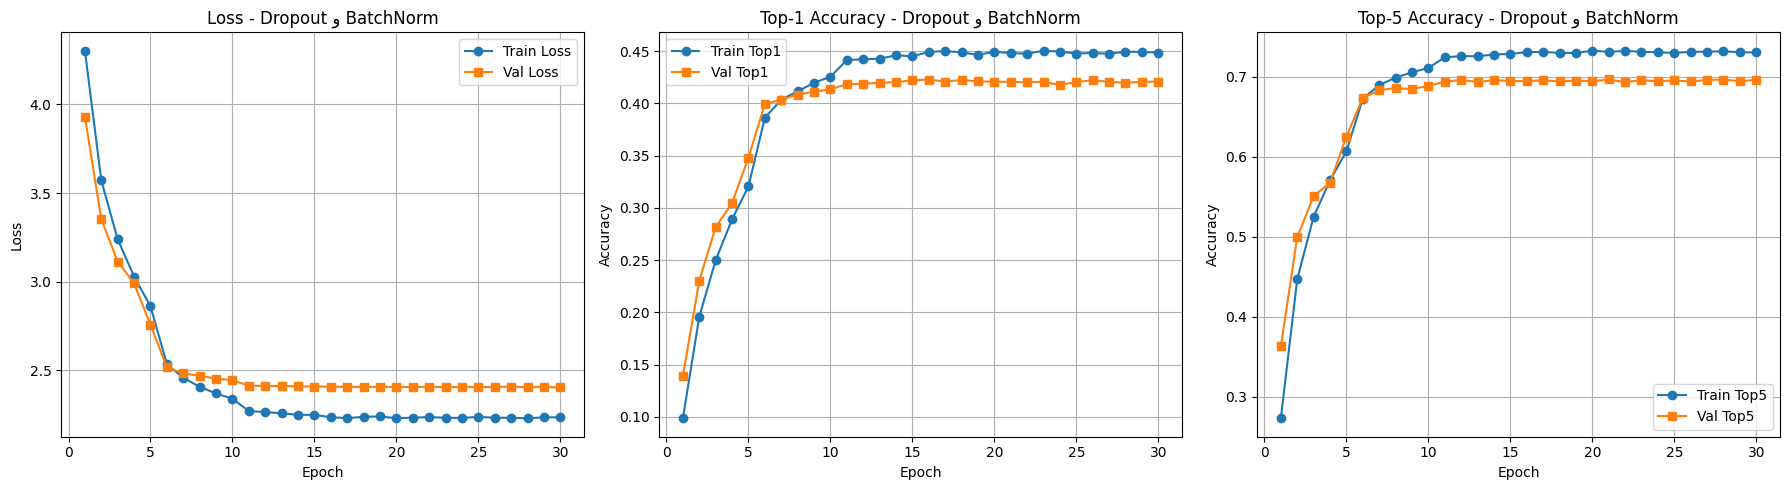

In [ ]:
bestWeightDecay = 0.0
bestLearningRate = 0.01
print("\n=== بخش ث: بررسی تاثیر Dropout و Batch Normalization ===\n")

print("ث: مدل با Dropout و BatchNorm")
model = ResIncepCNNWithBNDropout_All(numClasses=len(trainDataset.classes), dropoutProb=0.5).to(device)
optimizer = optim.SGD(model.parameters(), lr=bestLearningRate, momentum=0.9, weight_decay=bestWeightDecay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()
trainLossesBN, trainTop1BN, trainTop5BN, valLossesBN, valTop1BN, valTop5BN = trainModel(model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30)
plotMetrics(trainLossesBN, trainTop1BN, trainTop5BN, valLossesBN, valTop1BN, valTop5BN, "Dropout و BatchNorm")

# **EarlyStopping**

Epoch 1/30 | Train Loss: 4.2883, Train Top1: 0.0999, Train Top5: 0.2755 | Val Loss: 3.7028, Val Top1: 0.1740, Val Top5: 0.4148


Epoch 2/30 | Train Loss: 3.5609, Train Top1: 0.1951, Train Top5: 0.4508 | Val Loss: 3.3443, Val Top1: 0.2337, Val Top5: 0.4947


Epoch 3/30 | Train Loss: 3.2355, Train Top1: 0.2511, Train Top5: 0.5244 | Val Loss: 3.0962, Val Top1: 0.2830, Val Top5: 0.5558


Epoch 4/30 | Train Loss: 3.0203, Train Top1: 0.2920, Train Top5: 0.5721 | Val Loss: 2.9177, Val Top1: 0.3149, Val Top5: 0.5895


Epoch 5/30 | Train Loss: 2.8615, Train Top1: 0.3209, Train Top5: 0.6071 | Val Loss: 2.8051, Val Top1: 0.3310, Val Top5: 0.6136


Epoch 6/30 | Train Loss: 2.5338, Train Top1: 0.3853, Train Top5: 0.6733 | Val Loss: 2.5015, Val Top1: 0.4024, Val Top5: 0.6760


Epoch 7/30 | Train Loss: 2.4537, Train Top1: 0.4020, Train Top5: 0.6893 | Val Loss: 2.4797, Val Top1: 0.4118, Val Top5: 0.6796


Epoch 8/30 | Train Loss: 2.4085, Train Top1: 0.4116, Train Top5: 0.6989 | Val Loss: 2.4585, Val Top1: 0.4099, Val Top5: 0.6849


Epoch 9/30 | Train Loss: 2.3661, Train Top1: 0.4207, Train Top5: 0.7053 | Val Loss: 2.4374, Val Top1: 0.4152, Val Top5: 0.6860


Epoch 10/30 | Train Loss: 2.3318, Train Top1: 0.4262, Train Top5: 0.7129 | Val Loss: 2.4288, Val Top1: 0.4176, Val Top5: 0.6894


Epoch 11/30 | Train Loss: 2.2678, Train Top1: 0.4423, Train Top5: 0.7246 | Val Loss: 2.4102, Val Top1: 0.4220, Val Top5: 0.6945


Epoch 12/30 | Train Loss: 2.2573, Train Top1: 0.4429, Train Top5: 0.7266 | Val Loss: 2.4046, Val Top1: 0.4233, Val Top5: 0.6955


Epoch 13/30 | Train Loss: 2.2543, Train Top1: 0.4458, Train Top5: 0.7259 | Val Loss: 2.4034, Val Top1: 0.4228, Val Top5: 0.6952


Epoch 14/30 | Train Loss: 2.2483, Train Top1: 0.4471, Train Top5: 0.7267 | Val Loss: 2.4022, Val Top1: 0.4245, Val Top5: 0.6943


Epoch 15/30 | Train Loss: 2.2395, Train Top1: 0.4477, Train Top5: 0.7288 | Val Loss: 2.4014, Val Top1: 0.4248, Val Top5: 0.6940


Epoch 16/30 | Train Loss: 2.2342, Train Top1: 0.4488, Train Top5: 0.7289 | Val Loss: 2.4001, Val Top1: 0.4240, Val Top5: 0.6965


Epoch 17/30 | Train Loss: 2.2362, Train Top1: 0.4484, Train Top5: 0.7292 | Val Loss: 2.3977, Val Top1: 0.4240, Val Top5: 0.6959


Epoch 18/30 | Train Loss: 2.2329, Train Top1: 0.4477, Train Top5: 0.7304 | Val Loss: 2.3993, Val Top1: 0.4248, Val Top5: 0.6957


Epoch 19/30 | Train Loss: 2.2322, Train Top1: 0.4490, Train Top5: 0.7299 | Val Loss: 2.4038, Val Top1: 0.4237, Val Top5: 0.6947


Epoch 20/30 | Train Loss: 2.2315, Train Top1: 0.4493, Train Top5: 0.7303 | Val Loss: 2.3996, Val Top1: 0.4236, Val Top5: 0.6940


Epoch 21/30 | Train Loss: 2.2306, Train Top1: 0.4501, Train Top5: 0.7313 | Val Loss: 2.3998, Val Top1: 0.4233, Val Top5: 0.6958


Epoch 22/30 | Train Loss: 2.2302, Train Top1: 0.4500, Train Top5: 0.7307 | Val Loss: 2.3986, Val Top1: 0.4257, Val Top5: 0.6953
No improvement in validation loss for 5 epochs. Stopping training.
Early stopping triggered after 22 epochs


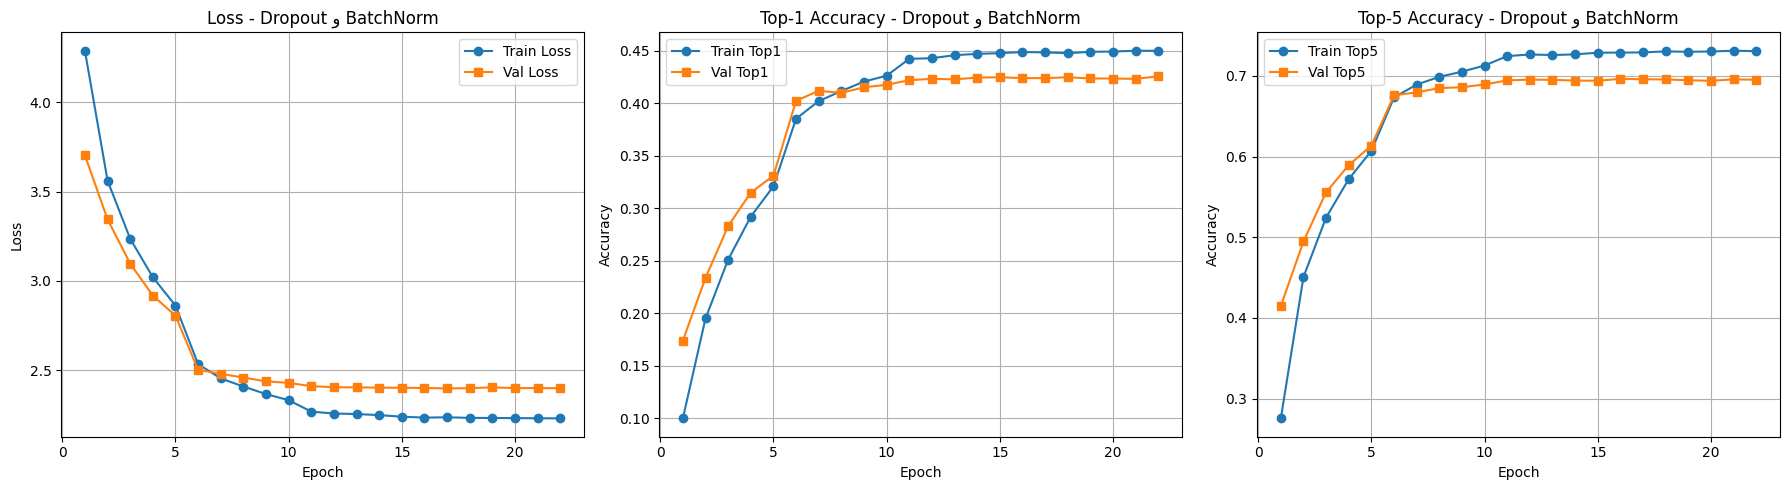

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

data_dir = "/content/custom_split"
trainDataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers=2)
valDataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=False, num_workers=2)

def topKAccuracy(output, target, k=1):
    _, pred = output.topk(k, dim=1, largest=True, sorted=True)
    correct = pred.eq(target.view(-1, 1).expand_as(pred))
    return correct.float().sum().item() / target.size(0)

def evaluate(model, loader):
    model.eval()
    runningLoss = 0.0
    runningTop1 = 0.0
    runningTop5 = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            runningLoss += loss.item()
            runningTop1 += topKAccuracy(outputs, labels, k=1)
            runningTop5 += topKAccuracy(outputs, labels, k=5)
    nBatches = len(loader)
    return runningLoss / nBatches, runningTop1 / nBatches, runningTop5 / nBatches

def trainModel(model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30, patience=5):
    trainLosses, trainTop1, trainTop5 = [], [], []
    valLosses, valTop1, valTop5 = [], [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(numEpochs):
        if early_stop:
            print(f"Early stopping triggered after {epoch} epochs")
            break

        model.train()
        runningLoss = 0.0
        runningAcc1 = 0.0
        runningAcc5 = 0.0
        for inputs, labels in tqdm(trainLoader, desc=f"Epoch {epoch+1}/{numEpochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
            runningAcc1 += topKAccuracy(outputs, labels, k=1)
            runningAcc5 += topKAccuracy(outputs, labels, k=5)

        if scheduler:
            scheduler.step()

        nBatchesTrain = len(trainLoader)
        trainLosses.append(runningLoss / nBatchesTrain)
        trainTop1.append(runningAcc1 / nBatchesTrain)
        trainTop5.append(runningAcc5 / nBatchesTrain)

        valLoss, valAcc1, valAcc5 = evaluate(model, valLoader)
        valLosses.append(valLoss)
        valTop1.append(valAcc1)
        valTop5.append(valAcc5)

        print(f"Epoch {epoch+1}/{numEpochs} | Train Loss: {trainLosses[-1]:.4f}, Train Top1: {trainTop1[-1]:.4f}, Train Top5: {trainTop5[-1]:.4f} | "
              f"Val Loss: {valLosses[-1]:.4f}, Val Top1: {valTop1[-1]:.4f}, Val Top5: {valTop5[-1]:.4f}")

        if valLoss < best_val_loss:
            best_val_loss = valLoss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
                early_stop = True

    return trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5

def plotMetrics(trainLosses, trainTop1, trainTop5, valLosses, valTop1, valTop5, title):
    epochs = list(range(1, len(trainLosses) + 1))
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, trainLosses, marker='o', label="Train Loss")
    plt.plot(epochs, valLosses, marker='s', label="Val Loss")
    plt.title(f"Loss - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, trainTop1, marker='o', label="Train Top1")
    plt.plot(epochs, valTop1, marker='s', label="Val Top1")
    plt.title(f"Top-1 Accuracy - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, trainTop5, marker='o', label="Train Top5")
    plt.plot(epochs, valTop5, marker='s', label="Val Top5")
    plt.title(f"Top-5 Accuracy - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    model = ResIncepCNNWithBNDropout_All(numClasses=len(trainDataset.classes), dropoutProb=0.5).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    trainLossesBN, trainTop1BN, trainTop5BN, valLossesBN, valTop1BN, valTop5BN = trainModel(
        model, trainLoader, valLoader, optimizer, scheduler, criterion, numEpochs=30, patience=5
    )

    plotMetrics(trainLossesBN, trainTop1BN, trainTop5BN, valLossesBN, valTop1BN, valTop5BN, "Dropout و BatchNorm")

In [ ]:
model_save_path = "resincep_cnn_bn_dropout.pth"
torch.save(model.state_dict(), model_save_path)
print(f"مدل در مسیر {model_save_path} ذخیره شد.")

مدل در مسیر resincep_cnn_bn_dropout.pth ذخیره شد.


# **Ray  Tune**

In [2]:
!pip install ray[tune]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 13.9 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip uninstall -y thinc spacy catalogue
!pip install numpy==1.26.4 --force-reinstall --quiet


Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: spacy 3.8.7
Uninstalling spacy-3.8.7:
  Successfully uninstalled spacy-3.8.7
Found existing installation: catalogue 2.0.10
Uninstalling catalogue-2.0.10:
  Successfully uninstalled catalogue-2.0.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires spacy<4, which is not installed.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter

class InceptionBlockBN(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(InceptionBlockBN, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.branch5 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, kernel_size=5, padding=2),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.branchPool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(inChannels, outChannels * 4, kernel_size=1),
            nn.BatchNorm2d(outChannels * 4)
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out1 = self.branch1(x)
        out3 = self.branch3(x)
        out5 = self.branch5(x)
        outPool = self.branchPool(x)
        out = torch.cat([out1, out3, out5, outPool], dim=1)
        return F.relu(out + residual)

class ResidualBlockBN(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(ResidualBlockBN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outChannels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outChannels)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, kernel_size=1),
            nn.BatchNorm2d(outChannels)
        )

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.conv2(out)
        return F.relu(out + identity)

class DynamicResIncepCNN(nn.Module):
    def __init__(self, config, numClasses=200, dropoutProb=0.5):
        super(DynamicResIncepCNN, self).__init__()
        c1, c2, c3, c4 = config["conv_channels1"], config["conv_channels2"], config["conv_channels3"], config["conv_channels4"]

        self.block1 = InceptionBlockBN(3, c1)
        self.pool1 = nn.MaxPool2d(2)

        self.block2 = ResidualBlockBN(c1 * 4, c2)
        self.pool2 = nn.MaxPool2d(2)

        self.block3 = InceptionBlockBN(c2, c3)
        self.pool3 = nn.MaxPool2d(2)

        self.block4 = ResidualBlockBN(c3 * 4, c4)
        self.pool4 = nn.MaxPool2d(2)

        self.globalPool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(c4, 512)
        self.bnFc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(p=dropoutProb)

        if config["num_fc_layers"] == 1:
            self.fc2 = nn.Linear(512, numClasses)
            self.extra_fc = None
        else:
            self.fc2 = nn.Linear(512, 256)
            self.extra_fc = nn.Linear(256, numClasses)

        self.num_fc_layers = config["num_fc_layers"]

    def forward(self, x):
        x = self.pool1(self.block1(x))
        x = self.pool2(self.block2(x))
        x = self.pool3(self.block3(x))
        x = self.pool4(self.block4(x))
        x = self.flatten(self.globalPool(x))
        x = self.dropout(F.relu(self.bnFc1(self.fc1(x))))
        x = self.fc2(x)
        if self.extra_fc:
            x = self.extra_fc(F.relu(x))
        return x


from ray.train import report
import traceback

def train_tune(config):
    try:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = DynamicResIncepCNN(config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-2)
        criterion = nn.CrossEntropyLoss()

        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        train_loader = DataLoader(
            datasets.ImageFolder("/content/custom_split/train", transform=transform),
            batch_size=64, shuffle=True, num_workers=2)
        val_loader = DataLoader(
            datasets.ImageFolder("/content/custom_split/validation", transform=transform),
            batch_size=64, shuffle=False, num_workers=2)

        for epoch in range(5):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                loss = criterion(model(inputs), labels)
                loss.backward()
                optimizer.step()

            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            acc = correct / total
            report({"accuracy": acc, "training_iteration": epoch})

    except Exception as e:
        print("🚨 An exception occurred:")
        traceback.print_exc()
        raise e  


# -------- تنظیمات Ray --------
search_space = {
    "conv_channels1": tune.choice([16, 32]),
    "conv_channels2": tune.choice([64, 128]),
    "conv_channels3": tune.choice([16, 32]),
    "conv_channels4": tune.choice([128, 256]),
    "num_fc_layers": tune.choice([1, 2, 3])
}

scheduler = ASHAScheduler(metric="accuracy", mode="max")
reporter = CLIReporter(metric_columns=["accuracy", "training_iteration"])
#import ray
#ray.shutdown()
#ray.init(ignore_reinit_error=True, num_cpus=2, include_dashboard=False)

tune.run(
    train_tune,
    config=search_space,
    num_samples=7,
    resources_per_trial={"cpu": 2, "gpu": 1},
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_ResIncepCNN",
    storage_path="/content/ray_results",  # همان مسیر قبلی
)



2025-06-04 09:39:30,962	INFO worker.py:1888 -- Started a local Ray instance.
2025-06-04 09:39:32,789	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-06-04 09:39:33,165	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+----------------------------------------------------------+
| Configuration for experiment     tune_ResIncepCNN        |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        AsyncHyperBandScheduler |
| Number of trials                 7                       |
+----------------------------------------------------------+

View detailed results here: /content/ray_results/tune_ResIncepCNN
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-06-04_09-39-28_468770_267/artifacts/2025-06-04_09-39-32/tune_ResIncepCNN/driver_artifacts`

Trial status: 7 PENDING
Current time: 2025-06-04 09:39:33. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status 